## Skorch callbacks

- https://jehyunlee.github.io/2022/06/09/Python-DL-8-skorch_callback/

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023. 7. 13</div>
<div style="text-align: right"> Last update: 2023. 7.13</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
from copy import deepcopy
import pickle
from tqdm.auto import tqdm

In [3]:
# font properties
plt.rcParams["mathtext.fontset"] = "cm"
font_label = {"color":"gray"}
font_title = {"color":"k"}
font_metrics = {'color':'k', 'fontsize':"medium"}

# colors
c_train = "green"
c_val = "orange"
c_test = "magenta"

PyTorch 사용 준비 & Random Seed

In [4]:
import torch
from torch import nn
from torch import optim

In [5]:
# GPU 사용 설정
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# GPU is not available


In [6]:
rng = np.random.RandomState(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

데이터

In [7]:
df_peng = sns.load_dataset("penguins")  # 펭귄 데이터셋
df_peng = df_peng.dropna()              # 결측치 제거

y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1)


In [8]:
from sklearn.model_selection import train_test_split

X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, 
                                                    stratify=X[["species", "island", "sex"]])
X_train, X_val, y_train, y_val = train_test_split(X_Train, y_Train, test_size=0.25, random_state=rng, 
                                                    stratify=X_Train[["species", "island", "sex"]])

In [9]:
cols_cat = ["species", "island", "sex"]

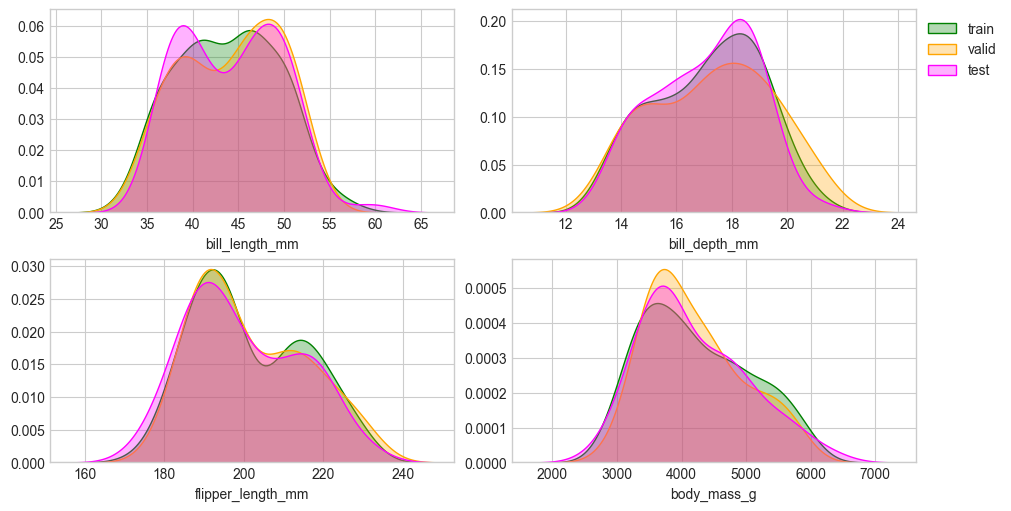

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 5), constrained_layout=True)

cols_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
axs = axes.ravel()

# numerical X features
for ax, col in zip(axes.ravel(), cols_num):
    for X, c in zip([X_train, X_val, X_test], [c_train, c_val, c_test]):
        sns.kdeplot(x=col, data=X, ax=ax, fill=True, alpha=0.3, color=c)
        ax.set_ylabel("")

# y feature
for y, c in zip([y_train, y_val, y_test], [c_train, c_val, c_test]):
    sns.kdeplot(y, ax=axes[1, 1], fill=True, alpha=0.3, color=c)
    axes[1, 1].set_ylabel("")

axes[0, 1].legend(handles=axes[1, 1].collections, labels=["train", "valid", "test"],
                  loc="upper left", bbox_to_anchor=(1, 1))

파이토치

In [11]:
# neural network: ninput(12)-16-16-12-8-1
class Net(nn.Module):
    def __init__(self, ninput=12):
        super().__init__()
        self.layer0 = nn.Linear(ninput, 16)
        self.layer1 = nn.Linear(16, 16)
        self.layer2 = nn.Linear(16, 12)
        self.layer3 = nn.Linear(12, 8)
        self.layer4 = nn.Linear(8, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer0(x))
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

# loss: RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
    def forward(self, true, pred):
        loss = torch.sqrt(self.mse(true, pred) + self.eps)
        return loss

전처리 파이프라인

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessings for Categorical and Numerical features
def get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    # categorical features: one-hot encoding
    cat_features = cols_cat
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # numerical features: standard scaling & polynomial features
    num_features = cols_num
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)),
                                      ("scaler", StandardScaler())])
    
    numcat = ColumnTransformer(transformers=[("categorical", cat_transformer, cat_features),
                                          ("numerical", num_transformer, num_features)])
    return numcat

# Float64 to Float32 for PyTorch
class FloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array(X, dtype=np.float32)


# preprocessing Pipeline
def get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    concat = get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    ft = FloatTransformer()

    pipeline= Pipeline(steps=[("concat", concat), 
                              ("float64to32", ft)])
    return pipeline

In [13]:
preprocessor = get_preprocessor()
preprocessor

Pipeline(steps=[('concat',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['species', 'island', 'sex']),
                                                 ('numerical',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures(degree=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('float64to32', FloatTransformer())])

In [14]:
# Xs
X_train_np = preprocessor.fit_transform(X_train)
X_val_np = preprocessor.transform(X_val)
X_test_np = preprocessor.transform(X_test)

X_train_tensor = torch.Tensor(X_train_np).to(device)
X_val_tensor = torch.Tensor(X_val_np).to(device)
X_test_tensor = torch.Tensor(X_test_np).to(device)

# ys
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)

In [15]:
# Xs
print(f"# dtype of X_train:\t\t{X_train.dtypes.values}")
print(f"# dtype of X_train_np:\t\t{X_train_np.dtype}")
print(f"# dtype of X_train_tensor:\t{X_train_tensor.dtype}\n")

# ys
print(f"# dtype of y_train:\t\t{y_train.dtype}")
print(f"# dtype of y_train_tensor:\t{y_train_tensor.dtype}")

# dtype of X_train:		[dtype('O') dtype('O') dtype('float64') dtype('float64') dtype('float64')
 dtype('O')]
# dtype of X_train_np:		float32
# dtype of X_train_tensor:	torch.float32

# dtype of y_train:		float64
# dtype of y_train_tensor:	torch.float32


training and validation

  0%|          | 0/1000 [00:00<?, ?it/s]

[0/1000] train_loss: 4303.2822265625,  valid_loss: 4250.70068359375
[100/1000] train_loss: 3756.332763671875,  valid_loss: 3660.7578125
[200/1000] train_loss: 361.5038757324219,  valid_loss: 295.0710144042969
[300/1000] train_loss: 289.6954650878906,  valid_loss: 275.1147766113281
[400/1000] train_loss: 282.8603210449219,  valid_loss: 271.2192687988281
[500/1000] train_loss: 280.0774230957031,  valid_loss: 271.82470703125
[600/1000] train_loss: 278.8686828613281,  valid_loss: 272.6382141113281
[700/1000] train_loss: 278.0510559082031,  valid_loss: 273.4936828613281
[800/1000] train_loss: 276.981201171875,  valid_loss: 274.990234375
[900/1000] train_loss: 276.1500244140625,  valid_loss: 276.0021057128906


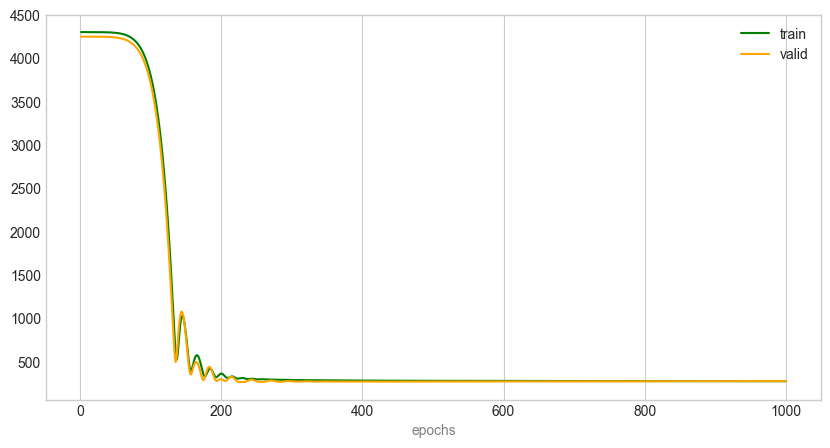

In [16]:
from torch.optim.lr_scheduler import OneCycleLR

net = Net().to(device)                      # Neural Network 생성
loss_fn = RMSELoss()                        # loss function 지정
optimizer = optim.Adam(net.parameters(), 
                       lr=1e-3)             # learning rate = 0.001
epochs = 1000                               # number of max. epochs
onecycle = OneCycleLR(optimizer,            # learning rate scheduler
                     max_lr=0.1, total_steps=epochs)

def train(device, model, epochs, loss_fn, optimizer, X_train, y_train, X_val=None, y_val=None, 
          lr_scheduler=None, early_stopping=1, patience=3, plot=True):
    loss_trains = []                            # train loss 
    loss_vals = []                              # validation loss
    loss_last = np.inf
    patience_ = 0

    val = False
    if X_val != None and y_val != None:
        val = True

    for epoch in tqdm(range(epochs)):
        model.train()                           # sets the model in training mode

        optimizer.zero_grad()                   # gradient reset
        y_pred = model.forward(X_train_tensor)  # forward propagation
        loss_ = loss_fn(y_pred, y_train_tensor.view(-1, 1)) # loss 계산
        loss_.backward()                        # back propagation
        optimizer.step()                        # weight update
        
        if lr_scheduler:
            lr_scheduler.step()                 # learning rate scheduler


        loss = loss_.item()
        loss_trains.append(loss)                # collect train loss

        # progress message
        prog_msg = f"[{epoch}/{epochs}] train_loss: {loss}"

        # validation
        if val == True:
            loss = validate(device, model, loss_fn, X_val, y_val)
            loss_vals.append(loss)          # collect validation loss
            prog_msg += f",  valid_loss: {loss}"
        
        if epoch % 100 == 0:
            print(prog_msg)

        # early stopping : patience회 이상 loss_val이 감소하지 않을 때
        if early_stopping > 0 and (loss > loss_last):
            patience_ += 1
            
            if patience_ >= patience:
                print(f"early stopping: {loss_last}")
                break
        
        loss_last = loss

    if plot:
        if val:
            plot_epoch(loss_trains, loss_vals)
        else:
            plot_epoch(loss_trains)

    return model


def validate(device, model, loss_fn, X_val, y_val):
    model.eval()                            # sets the model in evaluating mode

    with torch.no_grad():                   # gradient 계산 없이 진행
        y_pred = net.forward(X_val)         # forward propagation
        loss = loss_fn(y_pred, y_val.view(-1, 1))       # loss 계산
    
    return loss.item()


def plot_epoch(loss_trains, loss_vals=None, ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 5))
        
    ax.plot(list(range(1, len(loss_trains)+1)), loss_trains, c=c_train, label="train")
    if loss_vals != None:
        ax.plot(list(range(1, len(loss_vals)+1)), loss_vals, c=c_val, label="valid")
    ax.grid(axis="y")
    ax.set_xlabel("epochs", fontdict=font_label)
    ax.legend()
    
    return ax

net = train(device, net, epochs, loss_fn, optimizer, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
            lr_scheduler=None, early_stopping=0)

parity plot  
- training, valiation, testing set의 학습 결과를 비교하는 함수를 만듭니다.
- 참값(true)과 예측값(pred)을 scatter plot으로 그립니다.
- 여기에 MAE, RMSE, R2를 동시에 출력하는 함수를 만듭니다.


In [17]:
import matplotlib.colors as colors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def get_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred, squared=False)
    r2 = r2_score(true, pred)
    return mae, rmse, r2

def plot_parity(true, pred, kind="scatter", 
                xlabel="true", ylabel="predict", title="", 
                hist2d_kws=None, scatter_kws=None, kde_kws=None,
                equal=True, metrics=True, metrics_position="lower right",
                figsize=(5, 5), ax=None, filename=None):
    
    fig = None
    if not ax:
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # data range
    val_min = min(true.min(), pred.min())
    val_max = max(true.max(), pred.max())
    data_range = val_max - val_min

    # data plot
    if "scatter" in kind:
        if not scatter_kws:
            scatter_kws={'color':'green', 'alpha':0.5}
        ax.scatter(true, pred, **scatter_kws)
    elif "hist2d" in kind:
        if not hist2d_kws:
            hist2d_kws={'cmap':'Greens', 'vmin':1, 'bins':30}
        ax.hist2d(true, pred, **hist2d_kws)
    elif "kde" in kind:
        if not kde_kws:
            kde_kws={'cmap':'viridis', 'levels':5}
        sns.kdeplot(x=true, y=pred, **kde_kws, ax=ax)

    # x, y bounds
    bounds = (val_min - data_range*0.1, val_max + data_range*0.1)
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)

    # x, y ticks, ticklabels
    ticks = [int(y) for y in ax.get_yticks() if ((100*y)%100 == 0) and (val_min <= y <= val_max)]
    ax.set_xticks(ticks, ticks)
    ax.set_yticks(ticks, ticks)

    # grid
    ax.grid(True)

    # 기준선
    ax.plot(bounds, bounds, c="k", alpha=0.3)

    # x, y label
    font_label = {"color":"gray"}
    ax.set_xlabel(xlabel, fontdict=font_label, labelpad=12)
    ax.set_ylabel(ylabel, fontdict=font_label, labelpad=12)

    # title
    font_title = {"color": "gray", "fontweight":"bold"}
    ax.set_title(title, fontdict=font_title, pad=16)

    # metrics
    if metrics:
        rmse = mean_squared_error(true, pred, squared=False)
        mae = mean_absolute_error(true, pred)
        r2 = r2_score(true, pred)

        if metrics_position == "lower right":
            text_pos_x = 0.98
            text_pos_y = 0.3
            ha = "right"
        elif metrics_position == "upper left":
            text_pos_x = 0.1
            text_pos_y = 0.9
            ha = "left"
        else:
            text_pos_x, text_pos_y = metrics_position
            ha = "left"

        ax.text(text_pos_x, text_pos_y, f"RMSE = {rmse:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)
        ax.text(text_pos_x, text_pos_y-0.1, f"MAE = {mae:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)
        ax.text(text_pos_x, text_pos_y-0.2, f"R2 = {r2:.3f}", 
                transform=ax.transAxes, fontdict=font_metrics, ha=ha)

    # 파일로 저장
    if fig and filename:
            fig.savefig(filename)

    return ax

  0%|          | 0/1000 [00:00<?, ?it/s]

[0/1000] train_loss: 4303.0849609375,  valid_loss: 4250.50732421875
[100/1000] train_loss: 4298.97021484375,  valid_loss: 4246.09326171875
[200/1000] train_loss: 3950.37841796875,  valid_loss: 3884.753173828125
[300/1000] train_loss: 606.5177001953125,  valid_loss: 669.4122924804688
[400/1000] train_loss: 320.8173828125,  valid_loss: 296.94976806640625
[500/1000] train_loss: 306.0234069824219,  valid_loss: 281.51055908203125
[600/1000] train_loss: 299.0507507324219,  valid_loss: 276.0859375
[700/1000] train_loss: 294.1066589355469,  valid_loss: 272.74066162109375
[800/1000] train_loss: 290.1329040527344,  valid_loss: 270.5881652832031
[900/1000] train_loss: 287.0049743652344,  valid_loss: 269.0578308105469


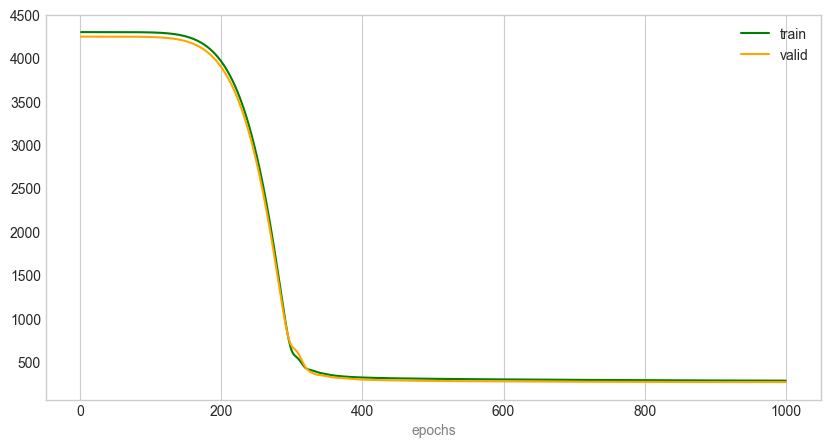

In [18]:
# evaluate training and validataion set
with torch.no_grad():
    y_pred_train = net.forward(X_train_tensor).cpu().numpy().flatten()
    y_pred_val = net.forward(X_val_tensor).cpu().numpy().flatten()
    
# hyperparameter 업데이트 했다고 치고, training + validataion set으로 refit
X_Train_pp = preprocessor.fit_transform(X_Train)
X_Train_tensor = torch.Tensor(X_Train_pp).to(device)
y_Train_tensor = torch.Tensor(y_Train).to(device)

net = Net().to(device)
loss_fn = RMSELoss()                        # loss function 지정
optimizer = optim.Adam(net.parameters(), 
                       lr=1e-3)             # learning rate = 0.001
epochs = 1000
net = train(device, net, epochs, loss_fn, optimizer, X_Train_tensor, y_Train_tensor, X_val_tensor, y_val_tensor, early_stopping=0)


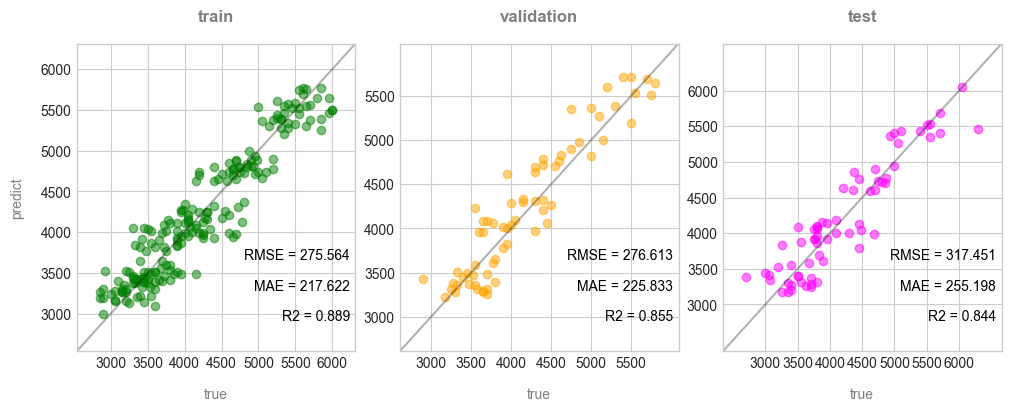

In [19]:
# evaluate testing set
with torch.no_grad():
    y_pred_test = net.forward(X_test_tensor).cpu().numpy().flatten()
    
# parity plots
fig, axs = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)

trues = [y_train, y_val, y_test]
preds = [y_pred_train, y_pred_val, y_pred_test]
colors = [c_train, c_val, c_test]
titles = ["train", "validation", "test"]
for ax, true, pred, c, title in zip(axs, trues, preds, colors, titles):
    plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
    if ax != axs[0]:
        ax.set_ylabel("")

In [20]:
def plot_parity3(model, target=["train", "val", "test"], figsize=(10, 4),
                 Xs=None, trues=None, preds=None, colors=None):
    if not Xs:
        Xs = [eval(f"X_{t}") for t in target]
    if not trues:
        trues = [eval(f"y_{t}") for t in target]
    if not preds:
        preds = [model.predict(X) for X in Xs]
    if not colors:
        colors = [eval(f"c_{t}") for t in target]

    fig, axs = plt.subplots(ncols=len(target), figsize=figsize, constrained_layout=True)
    for ax, true, pred, c, title in zip(axs, trues, preds, colors, titles):
        plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
        if ax != axs[0]:
            ax.set_ylabel("")

skorch

In [21]:
import skorch
from skorch import NeuralNetRegressor

In [22]:
# skorch로 PyTorch neural network wrapping
net_sk = NeuralNetRegressor(Net(), device=device, verbose=1,
                            criterion=RMSELoss,         # loss function
                            optimizer=optim.Adam,       # optimizer
                            optimizer__lr=1e-3)         # learning rate of the optimizer

# training
for epoch in range(300):
    net_sk.fit(X_train_np, y_train.astype(np.float32).values.reshape(-1, 1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4280.8804     4388.5337  0.0031
      2     4280.8696     4388.5225  0.0033
      3     4280.8584     4388.5117  0.0029
      4     4280.8481     4388.5010  0.0028
      5     4280.8373     4388.4907  0.0031
      6     4280.8271     4388.4800  0.0034
      7     4280.8167     4388.4697  0.0033
      8     4280.8061     4388.4590  0.0033
      9     4280.7953     4388.4482  0.0032
     10     4280.7846     4388.4375  0.0033
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4280.7737     4388.4263  0.0028
      2     4280.7630     4388.4150  0.0029
      3     4280.7512     4388.4028  0.0028
      4     4280.7391     4388.3906  0.0031
      5     4280.7264     4388.3779  0.0031
      6     4280.7136     4388.3643  0.0025
      7     4280.7000     4388.3516  0.002

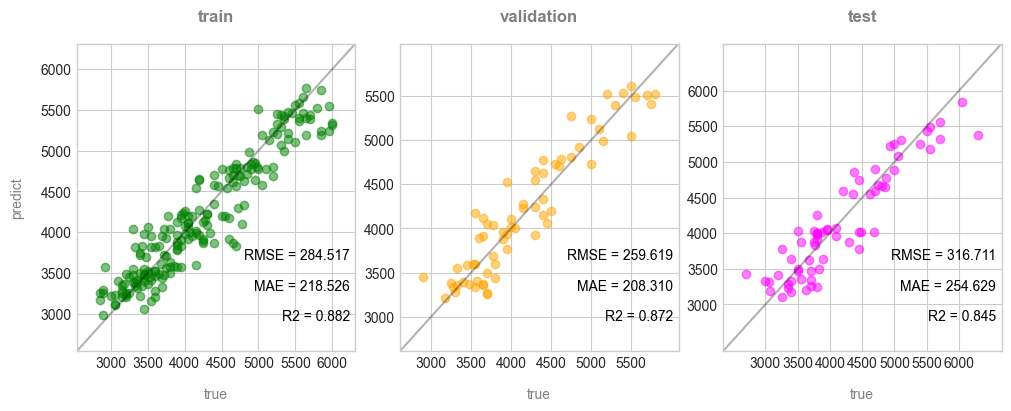

In [23]:
# prediction
y_pred_train = net_sk.predict(X_train_np)
y_pred_val = net_sk.predict(X_val_np)
y_pred_test = net_sk.predict(X_test_np)

# parity plot
plot_parity3(net_sk, Xs=[X_train_np, X_val_np, X_test_np])


ML pipeline

In [24]:
# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# embedding pytorch model in scikit-learn Pipeline
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.callbacks import Callback

# dynamic input size of the PyTorch module
class InputShapeSetter(Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__ninput=X.shape[1])

def get_model(method="lr", device=device, cols_cat=cols_cat, cols_num=cols_num, degree=1, 
              callbacks=[InputShapeSetter()], **kwargs):
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor(random_state=rng)
    elif method == "nn":
        ml = NeuralNetRegressor(Net(), device=device, callbacks=callbacks, **kwargs)
    else:
        print("# 'method' should be in ['lr', 'rf', 'nn'].")
        return None
    
    preprocessor = get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    model = Pipeline([("preprocessor", preprocessor), 
                      ("ml", ml)])
    
    return model

In [25]:
model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3)
model

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

In [26]:
model["ml"].get_params()

{'module': Net(
   (layer0): Linear(in_features=12, out_features=16, bias=True)
   (layer1): Linear(in_features=16, out_features=16, bias=True)
   (layer2): Linear(in_features=16, out_features=12, bias=True)
   (layer3): Linear(in_features=12, out_features=8, bias=True)
   (layer4): Linear(in_features=8, out_features=1, bias=True)
   (activation): ReLU()
 ),
 'criterion': __main__.RMSELoss,
 'optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'max_epochs': 1000,
 'batch_size': 128,
 'iterator_train': torch.utils.data.dataloader.DataLoader,
 'iterator_valid': torch.utils.data.dataloader.DataLoader,
 'dataset': skorch.dataset.Dataset,
 'train_split': <skorch.dataset.ValidSplit object at 0x29ad54130>,
 'callbacks': [<__main__.InputShapeSetter at 0x29c850f40>],
 'predict_nonlinearity': 'auto',
 'warm_start': False,
 'verbose': 1,
 'device': 'cpu',
 'compile': False,
 '_params_to_validate': {'optimizer__lr'},
 'optimizer__lr': 0.001,
 'callbacks__epoch_timer': <skorch.callbacks.logging.EpochT

In [27]:
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4281.0547     4388.7114  0.0027
      2     4281.0483     4388.7046  0.0027
      3     4281.0415     4388.6978  0.0028
      4     4281.0346     4388.6909  0.0029
      5     4281.0272     4388.6831  0.0031
      6     4281.0195     4388.6753  0.0030
      7     4281.0120     4388.6665  0.0030
      8     4281.0032     4388.6577  0.0034
      9     4280.9943     4388.6479  0.0027
     10     4280.9845     4388.6372  0.0027
     11     4280.9737     4388.6260  0.0030
     12     4280.9625     4388.6143  0.0029
     13     4280.9502     4388.6011  0.0027
     14     4280.9374     4388.5869  0.0029
     15     4280.9231     4388.5718  0.0025
     16     4280.9078     4388.5557  0.0028
     17     4280.8915     4388.5376  0.0025
     18     4280.8734    

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

(중 요)

- validation set을 입력하지 않았음에도 valid_loss가 출력됩니다.

- train data의 20%를 validation set으로 따로 떼어 놓기 때문입니다.

- 맨 처음 전체 데이터의 60%만 train set으로 지정했습니다.

- 여기서 다시 80%만 학습에 투입되었으니 총 48%. 반도 안되는 데이터로 학습한 셈입니다.

- train_split=None을 입력하면 모든 데이터를 다 학습에 투입하지만 validation 결과가 출력되지 않습니다.

- learning curve는 신경망에서 .history 속성을 추출해 확인할 수 있습니다.

<Axes: xlabel='epochs'>

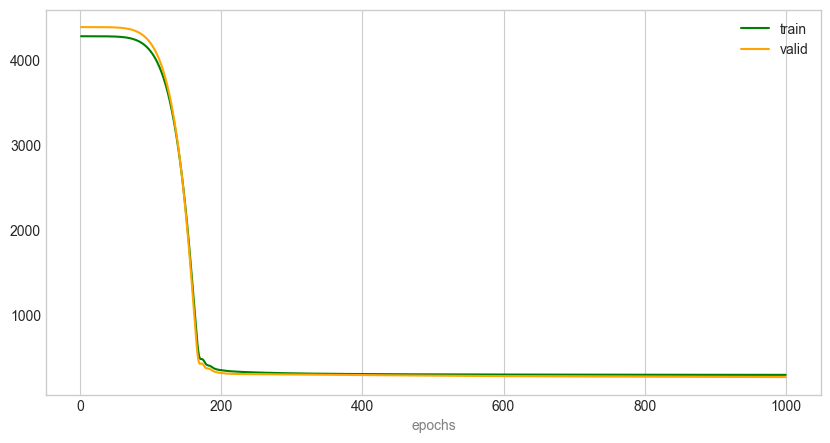

In [28]:
history = model["ml"].history
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]

plot_epoch(train_loss, valid_loss)

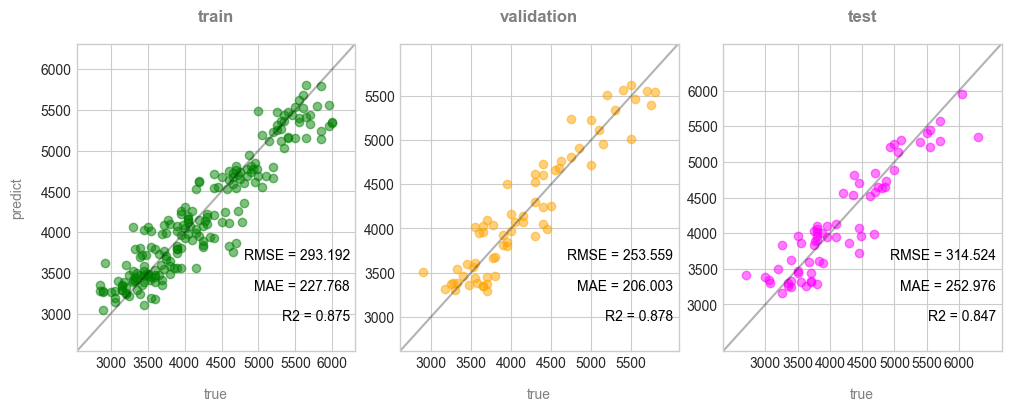

In [29]:
plot_parity3(model)


(중요)
- 먼저 준비한 validation set을 사용하려면 train_split에 validation set을 입력합니다.

- validation set은 skorch의 Dataset을 사용해 만듭니다.

- 내친 김에 y data도 ML Pipeline에 만들기 좋은 형태, 즉 float32, (-1, 1) shape으로 변경해서 모아놓습니다.

In [30]:
from skorch.dataset import Dataset

# ys (numpy)
y_train_np = y_train.values.reshape(-1, 1).astype(np.float32)
y_val_np = y_val.values.reshape(-1, 1).astype(np.float32)
y_test_np = y_test.values.reshape(-1, 1).astype(np.float32)

# predefined validation set
preprocessor = get_preprocessor()
X_val_pp = preprocessor.fit(X_train).transform(X_val)
valid_dataset = Dataset(X_val_pp, y_val_np)

# model training
model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  # predefined validataion set
                  train_split=predefined_split(valid_dataset))  
model.fit(X_train, y_train_np)

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4301.7759     4250.1558  0.0029
      2     4301.7627     4250.1421  0.0032
      3     4301.7489     4250.1279  0.0037


      4     4301.7347     4250.1128  0.0034
      5     4301.7196     4250.0977  0.0034
      6     4301.7050     4250.0835  0.0038
      7     4301.6911     4250.0708  0.0032
      8     4301.6781     4250.0576  0.0032
      9     4301.6654     4250.0444  0.0032
     10     4301.6521     4250.0308  0.0030
     11     4301.6381     4250.0166  0.0033
     12     4301.6234     4250.0015  0.0027
     13     4301.6083     4249.9854  0.0025
     14     4301.5920     4249.9683  0.0037
     15     4301.5752     4249.9507  0.0030
     16     4301.5570     4249.9321  0.0029
     17     4301.5378     4249.9121  0.0035
     18     4301.5178     4249.8906  0.0031
     19     4301.4963     4249.8677  0.0028
     20     4301.4735     4249.8438  0.0031
     21     4301.4493     4249.8179  0.0028
     22     4301.4226     4249.7900  0.0031
     23     4301.3941     4249.7593  0.0029
     24     4301.3632     4249.7261  0.0031
     25     4301.3295     4249.6895  0.0028
     26     4301.2922     4249.6

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

<Axes: xlabel='epochs'>

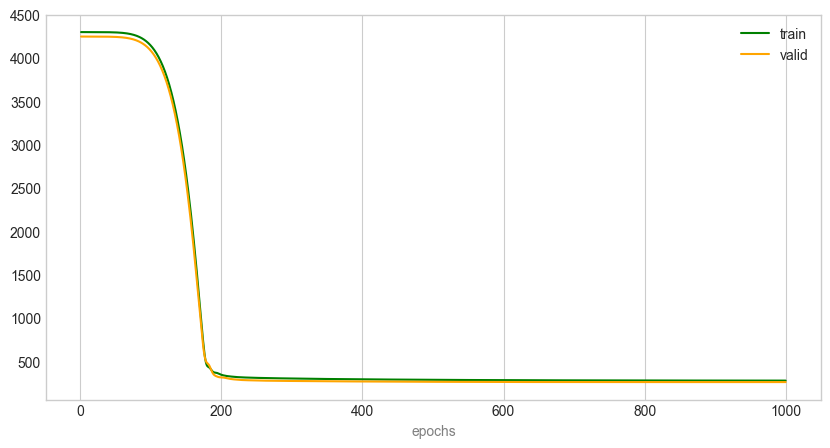

In [31]:
history = model["ml"].history
train_loss_0 = history[:, "train_loss"]
valid_loss_0 = history[:, "valid_loss"]

plot_epoch(train_loss_0, valid_loss_0)

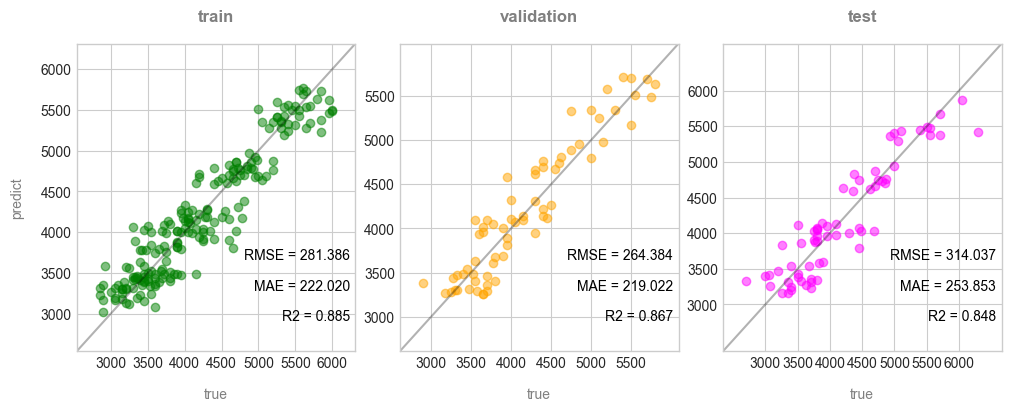

In [32]:
plot_parity3(model)

learning rate scheduler

callbacks에 learning late scheduler를 추가해 learning rate를 조정할 수 있습니다.  

input dimension 조정을 위해 callbacks 기본값으로 InputShapeSetter()가 들어가 있습니다.  

이를 삭제하지 않도록 유의하면서 learning rate scheduler를 추가합니다.  

In [33]:
from skorch.callbacks import LRScheduler

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  train_split=predefined_split(valid_dataset),               # predefined validataion set                
                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),
                             
                             # LR scheduler
                             ("lr_scheduler", LRScheduler(policy=OneCycleLR, # LR scheduler
                                                         max_lr=0.1,
                                                         total_steps=epochs))])
model.fit(X_train, y_train_np)

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1     4301.9115     4250.2798  0.0040  0.0030
      2     4301.8840     4250.2529  0.0040  0.0032
      3     4301.8571     4250.2256  0.0040  0.0034
      4     4301.8303     4250.1968  0.0040  0.0032
      5     4301.8011     4250.1655  0.0040  0.0032
      6     4301.7695     4250.1304  0.0041  0.0034
      7     4301.7337     4250.0903  0.0041  0.0033
      8     4301.6929     4250.0439  0.0041  0.0033
      9     4301.6455     4249.9888  0.0042  0.0033
     10     4301.5894     4249.9229  0.0042  0.0029
     11     4301.5211     4249.8413  0.0043  0.0032
     12     4301.4373     4249.7402  0.0043  0.0030
     13     4301.3335     4249.6147  0.0044  0.0029
     14     4301.2035     4249.4561  0.0044  0.0031
     15     4301.0395     424

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

러닝커브 비교

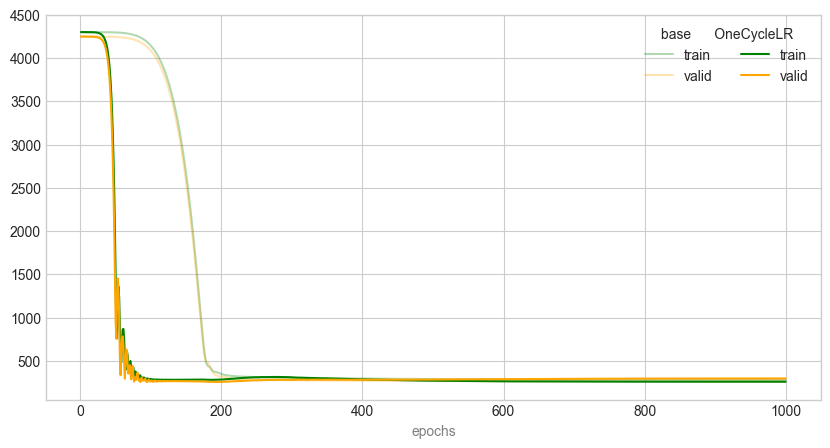

In [34]:
ax = plot_epoch(train_loss_0, valid_loss_0)
lines = ax.lines
for line in lines:
    line.set_alpha(0.3)

history = model["ml"].history
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]

ax = plot_epoch(train_loss, valid_loss, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncol=2, title="base      OneCycleLR")


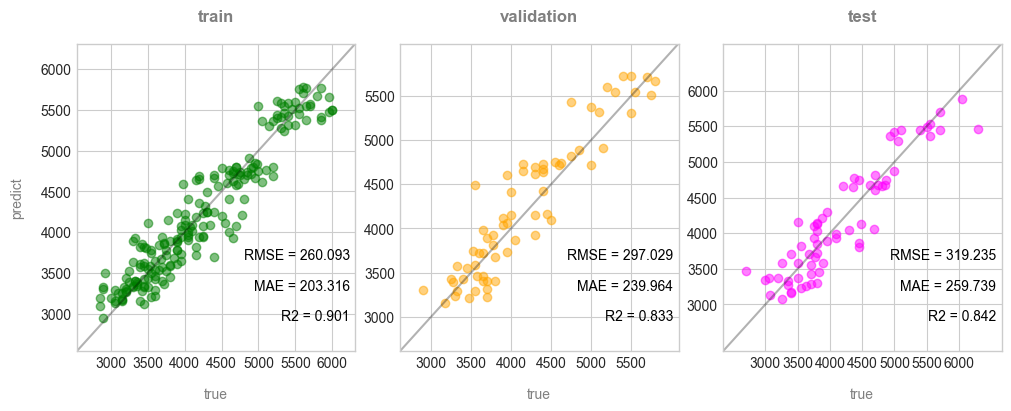

In [35]:
plot_parity3(model)

early stopping

In [36]:
from skorch.callbacks import EarlyStopping

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  train_split=predefined_split(valid_dataset),               # predefined validataion set        

                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),

                             # LR scheduler
                             ("lr_scheduler", LRScheduler(policy=OneCycleLR, 
                                                         max_lr=0.1,
                                                         total_steps=epochs)),

                             # early stopping
                             ("early_stopping", EarlyStopping(monitor="valid_loss",
                                                              patience=20))])
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1     4301.8012     4250.1572  0.0040  0.0031
      2     4301.7598     4250.1113  0.0040  0.0032
      3     4301.7127     4250.0586  0.0040  0.0035
      4     4301.6589     4249.9976  0.0040  0.0034
      5     4301.5970     4249.9258  0.0040  0.0037
      6     4301.5240     4249.8408  0.0041  0.0037
      7     4301.4376     4249.7402  0.0041  0.0034
      8     4301.3350     4249.6196  0.0041  0.0034
      9     4301.2116     4249.4751  0.0042  0.0031
     10     4301.0637     4249.2998  0.0042  0.0030
     11     4300.8837     4249.0845  0.0043  0.0032
     12     4300.6629     4248.8193  0.0043  0.0033
     13     4300.3916     4248.4927  0.0044  0.0028
     14     4300.0567     4248.0894  0.0044  0.0031
     15     4299.6409     424

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

(0.0, 200.0)

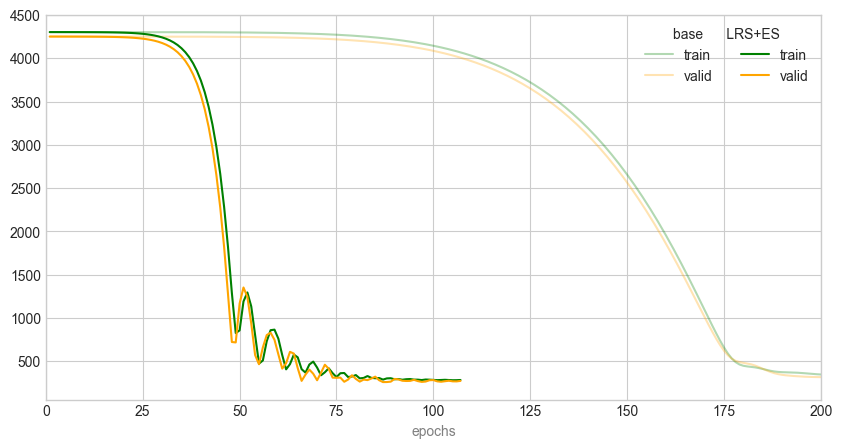

In [37]:
ax = plot_epoch(train_loss_0, valid_loss_0)
lines = ax.lines
for line in lines:
    line.set_alpha(0.3)

history = model["ml"].history
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]

ax = plot_epoch(train_loss, valid_loss, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, ncol=2, title="base      LRS+ES")
ax.set_xlim(0, 200)

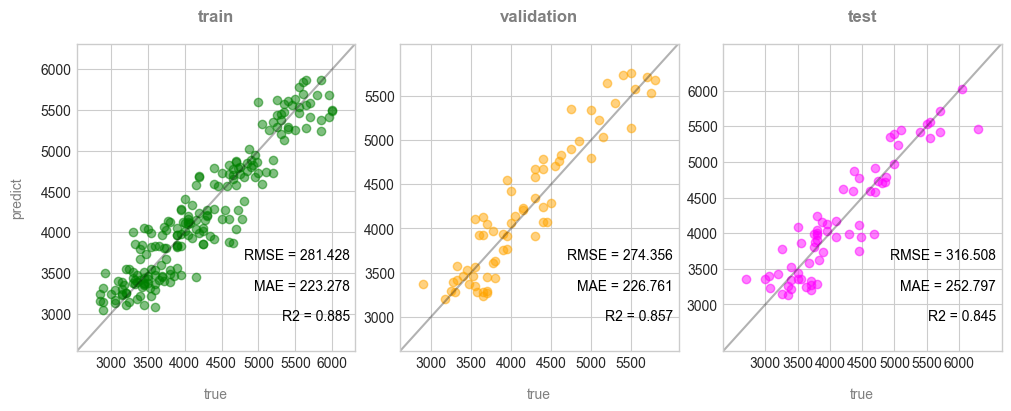

In [38]:
plot_parity3(model)


saving and loading

In [39]:
# save parameters
model["ml"].save_params(f_params="nn_params.pkl")


모델을 새로 만들면 paramter를 불러오기 전에 초기화하는 과정이 필요합니다.  

.initialize()를 사용합니다.  



In [40]:
# load parameters
model_new = get_model(method="nn")
model_new["ml"].initialize()
model_new["ml"].load_params(f_params="nn_params.pkl")


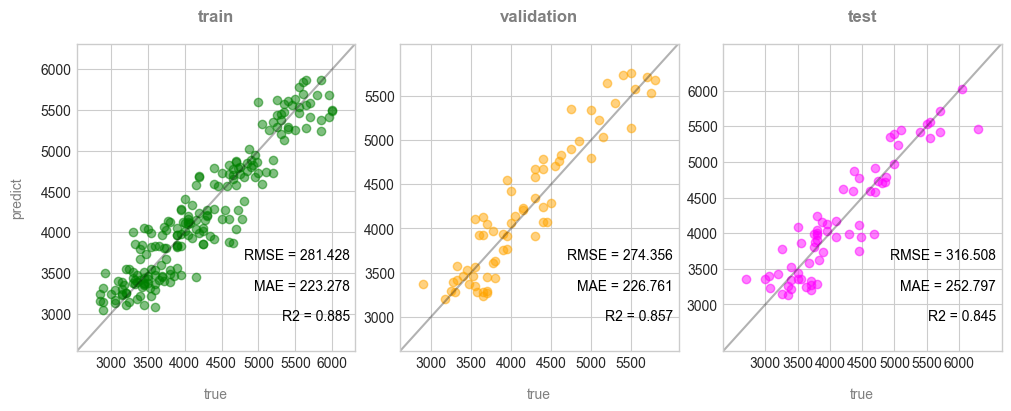

In [41]:
# check reproducibility
y_pred_train = model_new["ml"].predict(model["preprocessor"].transform(X_train))
y_pred_val = model_new["ml"].predict(model["preprocessor"].transform(X_val))
y_pred_test = model_new["ml"].predict(model["preprocessor"].transform(X_test))

plot_parity3(model_new, preds=[y_pred_train, y_pred_val, y_pred_test])

saving and loading callbacks

In [42]:
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

# save the model parameters, optimizer, and history
cp = Checkpoint(dirname='exp1')
train_end_cp = TrainEndCheckpoint(dirname='exp1')

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                  train_split=predefined_split(valid_dataset),                               

                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),

                             # LR scheduler
                             ("lr_scheduler", LRScheduler(policy=OneCycleLR, 
                                                         max_lr=0.1,
                                                         total_steps=epochs)),

                             # early stopping
                             ("early_stopping", EarlyStopping(monitor="valid_loss",
                                                              patience=20)),
                             
                             # Checkpoints
                             ("checkpoint", cp),
                             ("train_end_checkpoint", train_end_cp)
                             ])
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1     4301.9236     4250.2793     +  0.0040  0.0028
      2     4301.8835     4250.2441     +  0.0040  0.0030
      3     4301.8487     4250.2134     +  0.0040  0.0035


      4     4301.8180     4250.1836     +  0.0040  0.0032
      5     4301.7884     4250.1548     +  0.0040  0.0032
      6     4301.7601     4250.1255     +  0.0041  0.0030
      7     4301.7313     4250.0933     +  0.0041  0.0034
      8     4301.6980     4250.0522     +  0.0041  0.0029
      9     4301.6563     4250.0005     +  0.0042  0.0030
     10     4301.6036     4249.9331     +  0.0042  0.0035
     11     4301.5344     4249.8457     +  0.0043  0.0031
     12     4301.4454     4249.7344     +  0.0043  0.0030
     13     4301.3322     4249.5933     +  0.0044  0.0033
     14     4301.1884     4249.4150     +  0.0044  0.0029
     15     4301.0055     4249.1875     +  0.0045  0.0031
     16     4300.7723     4248.8975     +  0.0046  0.0029
     17     4300.4750     4248.5273     +  0.0047  0.0029
     18     4300.0952     4248.0542     +  0.0048  0.0028
     19     4299.6091     4247.4487     +  0.0049  0.0029
     20     4298.9867     4246.6758     +  0.0050  0.0031
     21     42

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

cp라는 열이 하나 생겼고, 여기 +가 붙은 곳들이 있습니다.  

valid_loss가 기존 기록보다 작아진 지점입니다.  

History도 파일에서 불러와서 그립니다.  

부를 때는 skorch.history.History를 사용합니다.  

세 개의 learning curve를 겹쳐 그리느라 코드가 다소 복잡해졌습니다.  

(0.0, 200.0)

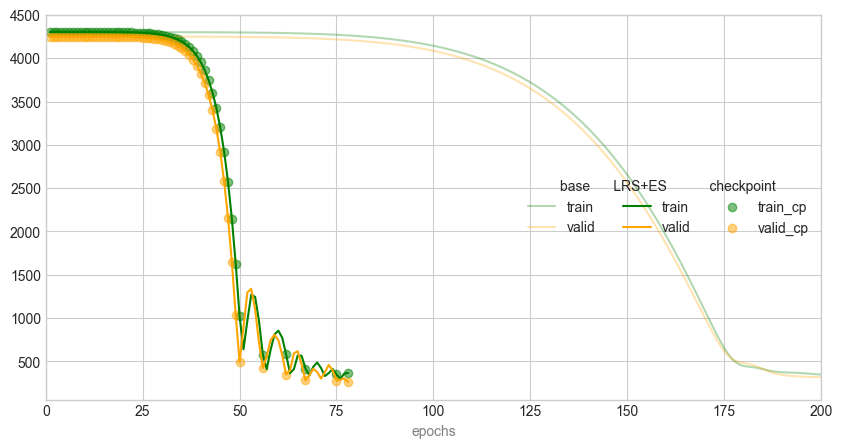

In [43]:
from skorch.history import History

# base plot
ax = plot_epoch(train_loss_0, valid_loss_0)
lines = ax.lines
for line in lines:
    line.set_alpha(0.3)

# history
history = History().from_file("./exp1/history.json")
train_loss = history[:, "train_loss"]
valid_loss = history[:, "valid_loss"]
ax = plot_epoch(train_loss, valid_loss, ax=ax)

# event_cp : cp == True
epoch = history[:, "epoch"]
event_cp = history[:, "event_cp"]
df_cp = pd.DataFrame({"epoch":epoch, "event_cp":event_cp, "train_loss":train_loss, "valid_loss":valid_loss})
df_cp = df_cp.loc[df_cp["event_cp"]==True]

ax.scatter(df_cp["epoch"], df_cp["train_loss"], fc=c_train, alpha=0.5, label="train_cp")
ax.scatter(df_cp["epoch"], df_cp["valid_loss"], fc=c_val, alpha=0.5, label="valid_cp")

ax.legend(ncol=3, title="base      LRS+ES           checkpoint", loc="center right")
ax.set_xlim(0, 200)

각 checkpoint에서는 history 외에도 criterion, optimizer, parameter 등의 상태를 저장합니다.

Colab 왼쪽의 폴더 모양을 클릭해 저장한 파일을 확인하면 볼 수 있습니다.

학습이 과하게 진행되어 overfitting이 되면 지나가버린 과거의 최적점이 아쉽습니다.

지나친 최적점을 불러와서 훨씬 낮은 learning rate로 살살 학습시키면 더 좋을 것 같습니다.

이 때 skorch에서 제공하는 LoadInitState를 사용할 수 있습니다.
cp = Checkpoint()로 저장된 위치를 지정하고,
load_state = LoadInitState(cp)로 불러와 상태를 불러옵니다.
마지막으로 callbacks에 cp와 load_state를 추가합니다

In [44]:
from skorch.callbacks import LoadInitState

cp = Checkpoint(dirname='exp1')
load_state = LoadInitState(cp)

model = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, 
                  # learning rate 조정
                  optimizer__lr = 1e-5,

                  # predefined validataion set
                  train_split=predefined_split(valid_dataset),                               

                  callbacks=[# input dimension setter
                             ("input_shape_setter", InputShapeSetter()),

                             # early stopping
                             ("early_stopping", EarlyStopping(monitor="valid_loss",
                                                              patience=100)),
                             
                             # Checkpoints
                             ("checkpoint", cp),
                             ("load_initial_state", load_state)
                             ])
model.fit(X_train, y_train.values.reshape(-1, 1).astype(np.float32))

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
     79      318.3011      293.5433     +  0.0030
     80      316.8857      353.3199        0.0031


     81      334.0686      322.2557        0.0035
     82      301.6022      284.5449     +  0.0033
     83      304.3105      294.7337        0.0033
     84      329.3902      281.9863     +  0.0032
     85      311.7566      278.7803     +  0.0035
     86      296.7053      310.5536        0.0032
     87      307.1565      300.1174        0.0031
     88      296.2852      266.6282     +  0.0032
     89      290.7395      266.6301        0.0031
     90      304.8373      270.8665        0.0033
     91      300.0320      281.9432        0.0029
     92      292.1460      305.1074        0.0031
     93      296.0268      298.6908        0.0031
     94      289.9250      274.0323        0.0032
     95      287.7008      265.2439     +  0.0030
     96      295.2777      263.6456     +  0.0031
     97      292.6411      272.0793        0.0031
     98      288.4158      286.6289        0.0029
     99      288.5222      283.8028        0.0029
    100      285.0237      273.3835        0.0032


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('concat',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['species',
                                                                    'island',
                                                                    'sex']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('polynomial',
                                                                                    PolynomialFeatures(degree=1)),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['bill_length_mm',
                                                                    'bill_depth_mm',
                                                                    'flipper_length_mm'])])),
                                 ('f...
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (layer0): Linear(in_features=12, out_features=16, bias=True)
    (layer1): Linear(in_features=16, out_features=16, bias=True)
    (layer2): Linear(in_features=16, out_features=12, bias=True)
    (layer3): Linear(in_features=12, out_features=8, bias=True)
    (layer4): Linear(in_features=8, out_features=1, bias=True)
    (activation): ReLU()
  ),
))])

모델 전체를 저장할 때는 pickle을 권장하고 있습니다.

pickle.dump()와 pickle.load()를 사용해 모델을 읽고 씁니다.

In [45]:
with open('skorch_dl.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# loading
with open('skorch_dl.pkl', 'rb') as f:
    model_pkl = pickle.load(f)

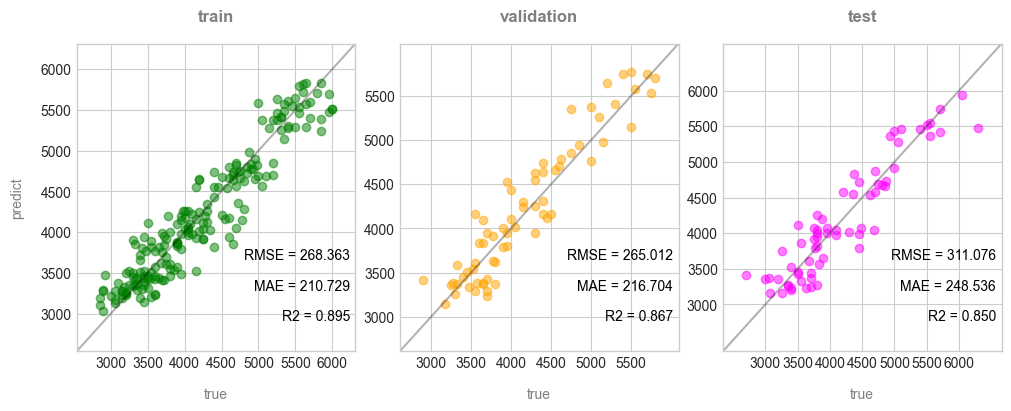

In [46]:
# check reproducibility
plot_parity3(model=model_pkl)

정리 코드

In [47]:
# preprocessors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessings for Categorical and Numerical features
def get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    # categorical features: one-hot encoding
    cat_features = cols_cat
    cat_transformer = OneHotEncoder(sparse=False, handle_unknown="ignore")

    # numerical features: standard scaling & polynomial features
    num_features = cols_num
    num_transformer = Pipeline(steps=[("polynomial", PolynomialFeatures(degree=degree)),
                                      ("scaler", StandardScaler())])
    
    numcat = ColumnTransformer(transformers=[("categorical", cat_transformer, cat_features),
                                          ("numerical", num_transformer, num_features)])
    return numcat

# Float64 to Float32 for PyTorch
class FloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.array(X, dtype=np.float32)


# preprocessing Pipeline
def get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=1):
    concat = get_concat(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    ft = FloatTransformer()

    pipeline= Pipeline(steps=[("concat", concat), 
                              ("float64to32", ft)])
    return pipeline

In [48]:
import torch
from torch import nn
from torch import optim

# neural network: ninput(12)-16-16-12-8-1
class Net(nn.Module):
    def __init__(self, ninput=12):
        super().__init__()
        self.layer0 = nn.Linear(ninput, 16)
        self.layer1 = nn.Linear(16, 16)
        self.layer2 = nn.Linear(16, 12)
        self.layer3 = nn.Linear(12, 8)
        self.layer4 = nn.Linear(8, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer0(x))
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x

# loss: RMSE
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
    def forward(self, true, pred):
        loss = torch.sqrt(self.mse(true, pred) + self.eps)
        return loss

In [49]:
# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# embedding pytorch model in scikit-learn Pipeline
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split

# callbacks
from skorch.callbacks import Callback
from skorch.callbacks import LRScheduler
from skorch.callbacks import EarlyStopping
from skorch.callbacks import Checkpoint, TrainEndCheckpoint

# dynamic input size of the PyTorch module
class InputShapeSetter(Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__ninput=X.shape[1])

# save the model parameters, optimizer, and history
cp = Checkpoint(dirname='exp_test')
train_end_cp = TrainEndCheckpoint(dirname='exp_test')

# skorch ML pipeline
def get_model(method="lr", device=device, cols_cat=cols_cat, cols_num=cols_num, degree=1, 
              callbacks=[("input_shape_setter", InputShapeSetter()),
                         ("lr_scheduler", LRScheduler(policy=OneCycleLR, max_lr=0.1, total_steps=epochs)),
                         ("early_stopping", EarlyStopping(monitor="valid_loss", patience=20)),
                         ("checkpoint", cp), ("train_end_checkpoint", train_end_cp)], 
              **kwargs):
    
    if method == "lr":
        ml = LinearRegression(fit_intercept=True)
    elif method == "rf":
        ml = RandomForestRegressor(random_state=rng)
    elif method == "nn":
        ml = NeuralNetRegressor(Net(), device=device, callbacks=callbacks, **kwargs)
    else:
        print("# 'method' should be in ['lr', 'rf', 'nn'].")
        return None
    
    preprocessor = get_preprocessor(cols_cat=cols_cat, cols_num=cols_num, degree=degree)
    model = Pipeline([("preprocessor", preprocessor), 
                      ("ml", ml)])
    
    return model

In [50]:
def plot_epoch(history=None, loss_trains=None, loss_vals=None, ax=None):
    
    if any([history, loss_trains]) == False:
        print("# one of 'history' and 'loss_trains' has to be used!")
        return ax
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if loss_trains == None:
        loss_trains = history[:, "train_loss"]

    if history != None and loss_vals == None:
        loss_vals = history[:, "valid_loss"]

    ax.plot(list(range(1, len(loss_trains)+1)), loss_trains, c=c_train, label="train")
    if loss_vals != None:
        ax.plot(list(range(1, len(loss_vals)+1)), loss_vals, c=c_val, label="valid")
    ax.grid(axis="y")
    ax.set_xlabel("epochs", fontdict=font_label)
    ax.legend()

    return ax

In [51]:
def plot_parity3(model, target=["train", "val", "test"], figsize=(10, 4),
                 Xs=None, trues=None, preds=None, colors=None):
    if not Xs:
        Xs = [eval(f"X_{t}") for t in target]
    if not trues:
        trues = [eval(f"y_{t}") for t in target]
    if not preds:
        preds = [model.predict(X) for X in Xs]
    if not colors:
        colors = [eval(f"c_{t}") for t in target]

    fig, axs = plt.subplots(ncols=len(target), figsize=figsize, constrained_layout=True)
    for ax, true, pred, c, title in zip(axs, trues, preds, colors, titles):
        plot_parity(true, pred, ax=ax, scatter_kws={"fc":c, "ec":c, "alpha":0.5}, title=title)
        if ax != axs[0]:
            ax.set_ylabel("")

테스트런

Re-initializing module because the following parameters were re-set: module__ninput.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      lr     dur
-------  ------------  ------------  ----  ------  ------
      1     4302.3603     4250.7104     +  0.0040  0.0030
      2     4302.3090     4250.6572     +  0.0040  0.0036


      3     4302.2551     4250.6030     +  0.0040  0.0034
      4     4302.2001     4250.5454     +  0.0040  0.0036
      5     4302.1412     4250.4819     +  0.0040  0.0030
      6     4302.0762     4250.4111     +  0.0041  0.0031
      7     4302.0036     4250.3320     +  0.0041  0.0028
      8     4301.9218     4250.2412     +  0.0041  0.0032
      9     4301.8281     4250.1362     +  0.0042  0.0030
     10     4301.7193     4250.0127     +  0.0042  0.0029
     11     4301.5911     4249.8643     +  0.0043  0.0029
     12     4301.4373     4249.6851     +  0.0043  0.0027
     13     4301.2507     4249.4668     +  0.0044  0.0029
     14     4301.0232     4249.1992     +  0.0044  0.0029
     15     4300.7433     4248.8687     +  0.0045  0.0028
     16     4300.3979     4248.4609     +  0.0046  0.0033
     17     4299.9710     4247.9556     +  0.0047  0.0029
     18     4299.4420     4247.3276     +  0.0048  0.0032
     19     4298.7851     4246.5464     +  0.0049  0.0032
     20     42

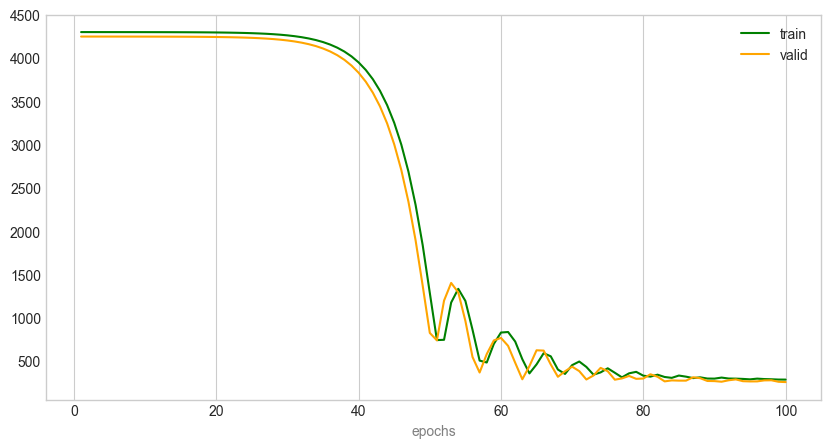

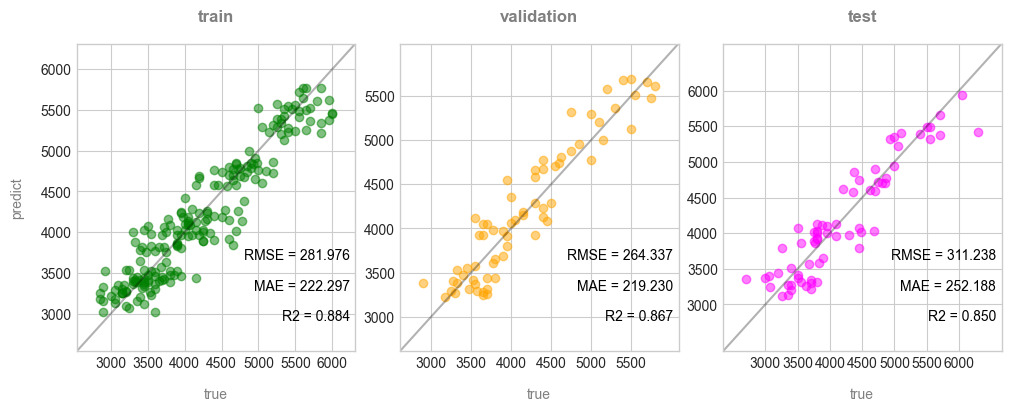

In [52]:
# predefined validation set
preprocessor = get_preprocessor()
X_val_pp = preprocessor.fit(X_train).transform(X_val)
valid_dataset = Dataset(X_val_pp, y_val_np)

# ML pipeline preparation
model_test = get_model("nn", max_epochs=epochs, verbose=1, criterion=RMSELoss, optimizer=optim.Adam, optimizer__lr = 1e-3,
                       train_split=predefined_split(valid_dataset))
model_test.fit(X_train, y_train_np)

# learning curve
history = History().from_file("./exp_test/history.json")
ax = plot_epoch(history)

# parity plots
plot_parity3(model_test)